In [1]:
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import os
from collections import *
import requests as r
import warnings
from io import BytesIO
from dataclasses import dataclass



## Base params

warnings.simplefilter(action='ignore')
tqdm.pandas()
plt.style.use('ggplot')
pd.set_option('use_inf_as_na', True)
plt.rcParams['figure.figsize'] = (15,6)


In [2]:
df = pd.read_csv('../data/price-volume-minute_btc-usd.csv',header=None)
df.columns = ['price','volume','datetime']
df['datetime'] = df['datetime'].astype('datetime64[ms]')
df = df.set_index('datetime').sort_index()

In [3]:
def query(q,url='http://85.193.83.20:8123',format=True,**kwargs):
    if format:
        return pd.read_csv(BytesIO(r.post(url=url,
                data=(q+'\nFORMAT CSVWithNames').encode('utf-8'),
                auth= (os.getenv('CRYPTO_ETL_USER'),os.getenv('CRYPTO_ETL_PASSWORD'))
                ).content),**kwargs)
    
    else:
        return r.post(url=url,
                data=q.encode('utf-8'),
                auth=(os.getenv('CRYPTO_ETL_USER'),os.getenv('CRYPTO_ETL_PASSWORD')))
    

In [4]:
def rsi_calc(df,w=14):
    wsa = (100 - 100 / df.pct_change().where(lambda x: x>0).rolling(w,1).mean().div(df.pct_change().where(lambda x: x<0).rolling(w,1).mean().abs()).add(1))
    rsi = wsa.shift(1).mul(w-1).add(wsa).div(w)
    return rsi

In [5]:
def calc_mfi(df,price_col='price',vol_col='volume',kandle=12,mfi_range=1800):
    dd = df.copy()
    dd[price_col] = dd[price_col].rolling(kandle,1).mean()
    pmf = dd.where(dd[price_col].diff() > 0).rolling(mfi_range,1).agg({price_col:'sum',vol_col:'sum'}) 
    pmf = pmf[price_col] * pmf[vol_col]
    nmf = dd.where(dd[price_col].diff() < 0).rolling(mfi_range,1).agg({price_col:'sum',vol_col:'sum'}) 
    nmf = nmf[price_col] * nmf[vol_col]
    return 100 - 100/(1 + pmf/nmf)

In [6]:
def check_cross(data,value_col ='price' ,rolling_fast = 10,rolling_slow = 100, cross_window = 10,**kwargs ):
    zz = data.copy()
    zz['r_fast'] = zz[value_col].rolling(rolling_fast,1).mean()
    zz['r_slow'] = zz[value_col].rolling(rolling_slow,1).mean()

    zz['rolling_diff'] = zz['r_fast'] - zz['r_slow']

    zz['is_buy_cross'] = (zz['rolling_diff'] >0) & (zz['rolling_diff'].shift(cross_window) < 0)

    return (zz['is_buy_cross'].iloc[-1])# & all(zz[value_col].iloc[-cross_window:] < np.minimum(zz['r_fast'].iloc[-cross_window],zz['r_slow'].iloc[-cross_window]))

In [7]:
def under_rolling(df,value_col ='price' ):
    for i in np.arange(5,100,5):
        df[f'{i}_roll'] = df[value_col].rolling(i,1).mean()
    return df.iloc[:,1:].sub(df[value_col],axis=0).sum(axis=1)>0

In [9]:
def devirgence(data,shift=10):
    f1 = data
    f2 = data.shift(shift)
    return f1 / f2 - 1
def div_check(data,price_col='price',vol_col='volume',price_coef= 0,index_coef = 0,shift=30):
    price_dv = devirgence(data[price_col],shift=shift)
    mfi_dv = devirgence(calc_mfi(data,vol_col=vol_col,price_col=price_col),shift=shift)
    return (price_dv < price_coef) & (mfi_dv >index_coef)

qq = query('''
select toStartOfInterval(toDateTime(trade_time/1000), interval 1 minute) as t, 
count(trade_id)  trades_count,
avg(price)  as avg_price
from crypto.binancews_trade
where t>'2022-01-21'
group by t
order by t

''').astype({'t':'datetime64[ms]'}).set_index('t')

In [10]:
len(df['price'].shape)

1

In [11]:
@dataclass
class TradeBotBase:
    '''
    Базовый каркас проверки моделей торговли, возможно будет в будущем каркасом бота\n
    Создаем Сущность которая будет внутри себя иметь все основные эдементы для торговли\n
    Закладываем то, что понадобится для всех моделей - базовые параметры + общий функционал
    
    Класс не содержет стратегий покупки, т.к. они будут формироваться дочерними классами\n
    Главным способом взаимодействия будет являться модуль models_result\n
    В него дочерние классы будут писать свои результаты и по ним уже модуль fetch_deals будет совершать операции

    '''
    name : str = 'Vasya'
    deposit : int = 100000 # наш начальный гонорар \ при первом приближении покупаем по 1 целой монетке
    trade_fee : float = .001 # торговая пошлина
    profit : float = .001 # Величина минимального профита для продажи
    stoploss : float = 0.05 # величина стоплоса \ простой стоплосс
    
    def __post_init__(self):
        '''
        Задаем базовые параметры моделек
        '''
        self.models_result = {} # собираем решения о покупке от нескольких стратегий
        self.coin_pool = {} # храним информацию о том, за сколько и когда мы купили монетку
        self.deals_dict = {'sell':[],'buy':[]} # храним простую статистику покупок \ продаж *даты*
        self.cash_flow = {} # статистика по тоталу нашего кошелька после каждой сделки
        self.ttl_profit = defaultdict(int) # статистика нашего профита после каждой сделки

    def get_data(self,df,price_col='price'):
        '''
        df : DataFrame \n
        Передаем сюда данные по ценам.\n
        индекс - datetime в минутном разрезе\n
        значения - среднее значение по торгам \ в свечке
        '''
        self.df = df
        if len(df.shape)==1:
            self.current_price = df.values[-1] # запоминаем цену и даты, часто будем переиспользовать
        else:
            self.current_price = df[price_col].values[-1]
        self.current_dt = df.index[-1]


    def buy (self):
        '''
        Атомарная функция покупки и записи статистики\n
        Является кнопкой "Тратить деньги"
        
        '''
        self.coin_pool[self.current_dt] = self.current_price # Забираем монетку в кошель и знаем о том когда и за сколько мы ее купили
        self.deposit -= self.current_price*(1 + self.trade_fee) # За покупку мы снимаем с кошеля стоимость монеты + пошлину
        self.cash_flow [self.current_dt] = self.deposit # Запоминаем наш cash flow для анализа и статистики
        self.deals_dict['buy'].append(self.current_dt) # Запоминаем когда сделали сделку для статистики
        
        return self

    def sell (self,order):
        '''
        Атомарная функция продажи и записи статистики\n
        Является кнопкой "Получеть деньги"
        
        '''
        self.deposit += self.current_price*(1 - self.trade_fee) # За продажу мы снимаем с кошеля стоимость монеты + пошлину
        self.deals_dict['sell'].append(self.current_dt)
        self.cash_flow [self.current_dt] = self.deposit
        self.ttl_profit[self.current_dt] += self.current_price*(1 - self.trade_fee) - self.coin_pool[order]*(1 + self.trade_fee) # Запоминаем наш профит со сделки
        del self.coin_pool[order] # Убираем монетку с нашего кошеля, которую мы продали
        return self

    def check_sell(self,order):
        '''
        Функция проверки целесообразности продажи\n
        В себе так же содержит stoploss\n
        '''
        profit_pct = self.profit

        if self.current_price / self.coin_pool[order] > 1 + profit_pct: # если продажа монетка дороже на n% стоимости ее покупки то продаем
            self.sell(order)
            
        elif self.current_price / self.coin_pool[order] < 1 - self.stoploss: # если монетка подешевела более чем на n% то продаем
            self.sell(order)

        return self


    def fetch_deals(self,is_any_strategy=True):
        '''
        Общая функция проверки состояния последнего поступившего сигнала\n
        Т.е. функция принятия решения по продажам\покупкам в момент времени
        
        '''
        buy_datetimes = list(self.coin_pool.keys()) #Получаем список монеток которые у нас есть в кошеле

        for deal in buy_datetimes:
            self.check_sell(deal) # Для каждой из них проверяем - не стоит ли продать или стоплосснуть

        if self.deposit > self.current_price: # В целом если у нас есть деньги на покупку по текущей стоимости - начинаем проверки на покупку

            if is_any_strategy:
                if any(self.models_result.values())==True: # Если хотя бы одна стратегия сработата, то инициируем покупку
                    self.buy()
            else:
                if all(self.models_result.values())==True: # Если все стратегии сработати, то инициируем покупку
                    self.buy()
        return self
    

In [12]:
@dataclass
class TradeBotRsi(TradeBotBase):
    '''
    Модель простой стратегии для примера\n
    Наследуем все основные свойства базового класса для консистентности \n

    Основная задача модуля - добавить функцию, которая на вход получит информацию\n
    На выходе она должна добавить в словарь models_result свое название и решение о покупке виде True \ False

    Последовательность обработки данных :
    1) get_data - для получение актуального состояния модели
    2) *model*_check() - рассчет и обработка данных для принятия решений
    3) fetch_deals - для обработки логики принятия решений с учетом ответа модели
    '''    
    def rsi_check(self,rsi_thr=20):
        self.models_result['rsi_check'] = rsi_calc(self.df)[-1]<rsi_thr
        return self.models_result


In [13]:
@dataclass
class TradeBotMFI(TradeBotBase):
        
    def mfi_check(self,price_col,vol_col):
        self.models_result['mfi'] = calc_mfi(self.df,price_col=price_col,vol_col=vol_col).iloc[-1] < 30
        return self.models_result


In [57]:
@dataclass
class TradeBotMFI_Div(TradeBotBase):
        
    def strat_check(self,price_col,vol_col):
        self.models_result['dev_mfi'] = div_check(self.df,price_col=price_col,vol_col=vol_col,price_coef=-.018,index_coef=.019,shift=230).iloc[-1]
        return self.models_result


In [18]:
@dataclass
class TradeBotCross(TradeBotBase):
        
    def cross_check(self):
        self.models_result['cross_check'] = check_cross(self.df.to_frame())
        return self.models_result


In [19]:
@dataclass
class TradeBotUnderRoll(TradeBotBase):

    def underroll(self):
        self.models_result['underroll'] = under_rolling(self.df.to_frame()).iloc[-1]
        return self.models_result


In [93]:
# Основной этап тестирования - определяем наши стратегии в виде объектов
# Имитируем ежедневный прирост информации , подавай порционно данные с интервалом 1 минута
# Ну и выполняем основные шаги наших роботиков

rsi_bot = TradeBotRsi(name = 'Oleg',stoploss=0.05,profit=0.02)
mfi_bot = TradeBotMFI(name = 'Oleg',stoploss=0.05,profit=0.02)
div_bot = TradeBotMFI_Div(name = 'Oleg',stoploss=0.05,profit=0.02)
cross_bot = TradeBotCross(name = 'Vitek',stoploss=0.05,profit=0.02)
under_bot = TradeBotUnderRoll(name = 'Vitek',stoploss=0.05,profit=0.02)

test_range = 10000
idxx = np.random.randint(df.loc['2021'].shape[0] - test_range)
for i in tqdm(range(1,test_range)):

    rsi_bot.get_data(df.loc['2021']['price'].iloc[idxx:idxx+i],price_col='price')
    rsi_bot.rsi_check()
    rsi_bot.fetch_deals()

    cross_bot.get_data(df.loc['2021']['price'].iloc[idxx:idxx+i],price_col='price')
    cross_bot.cross_check()
    cross_bot.fetch_deals()

    under_bot.get_data(df.loc['2021']['price'].iloc[idxx:idxx+i],price_col='price')
    under_bot.underroll()
    under_bot.fetch_deals()

    mfi_bot.get_data(df.loc['2021'].iloc[idxx:idxx+i],price_col='price')
    mfi_bot.mfi_check(price_col='price',vol_col='volume')
    mfi_bot.fetch_deals()

    div_bot.get_data(df.loc['2021'].iloc[idxx:idxx+i],price_col='price')
    div_bot.strat_check(price_col='price',vol_col='volume')
    div_bot.fetch_deals()


100%|██████████| 9999/9999 [04:18<00:00, 38.63it/s]


In [94]:
cross_pr = np.sum(list(map(lambda x: cross_bot.current_price - x, list(cross_bot.coin_pool.values())))) + np.sum(list(cross_bot.ttl_profit.values()))
rsi_pr = np.sum(list(map(lambda x: rsi_bot.current_price - x, list(rsi_bot.coin_pool.values())))) + np.sum(list(rsi_bot.ttl_profit.values()))
mfi_pr = np.sum(list(map(lambda x: mfi_bot.current_price - x, list(mfi_bot.coin_pool.values())))) + np.sum(list(mfi_bot.ttl_profit.values()))
div_pr = np.sum(list(map(lambda x: div_bot.current_price - x, list(div_bot.coin_pool.values())))) + np.sum(list(div_bot.ttl_profit.values()))
under_bot_pr = np.sum(list(map(lambda x: under_bot.current_price - x, list(under_bot.coin_pool.values())))) + np.sum(list(under_bot.ttl_profit.values()))

In [95]:
# Инфа сколько по итогу мы ушатали денег ;)
print(f'rsi_profit : {rsi_pr:.0f}\n\
mfi_profit : {mfi_pr:.0f}\n\
div_profit : {div_pr:.0f}\n\
cross_profit : {cross_pr:.0f}\n\
under_bot_profit : {under_bot_pr:.0f}')

rsi_profit : -10564
mfi_profit : 1010
div_profit : 1810
cross_profit : -5761
under_bot_profit : -4905


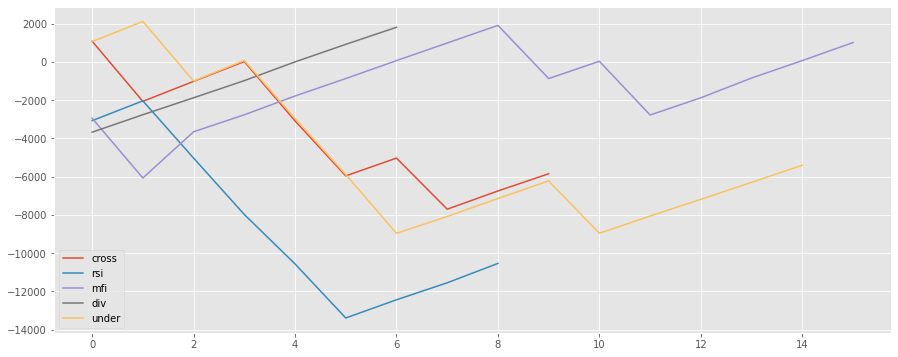

In [96]:
# График профита
pd.Series(cross_bot.ttl_profit).cumsum().reset_index(drop=True).plot()
pd.Series(rsi_bot.ttl_profit).cumsum().reset_index(drop=True).plot()
pd.Series(mfi_bot.ttl_profit).cumsum().reset_index(drop=True).plot()
pd.Series(div_bot.ttl_profit).cumsum().reset_index(drop=True).plot()
pd.Series(under_bot.ttl_profit).cumsum().reset_index(drop=True).plot()
plt.legend(['cross','rsi','mfi','div','under'])

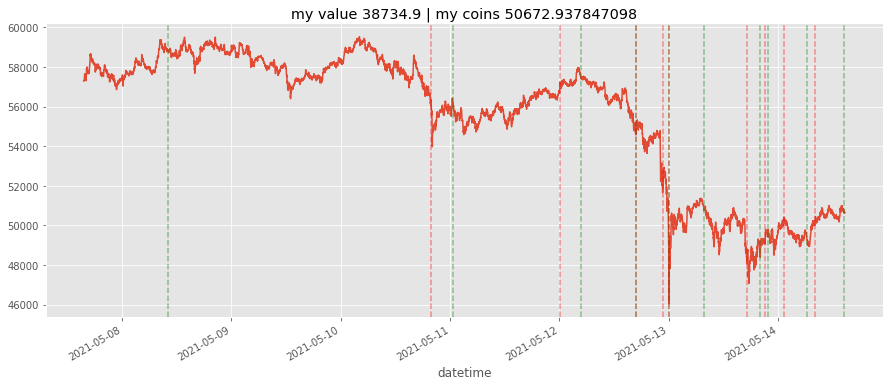

In [97]:
# Визуальный ряд с инфой где мы закупались и где продавали
df.loc['2021']['price'].iloc[idxx:idxx+i].plot(title=f'my value {rsi_bot.deposit:.1f} | my coins {np.sum(list(rsi_bot.coin_pool.values()))}')
[plt.axvline(dt,linestyle='--',color='g',alpha=.4) for dt in rsi_bot.deals_dict['buy']];
[plt.axvline(dt,linestyle='--',color='r',alpha=.4) for dt in rsi_bot.deals_dict['sell']];


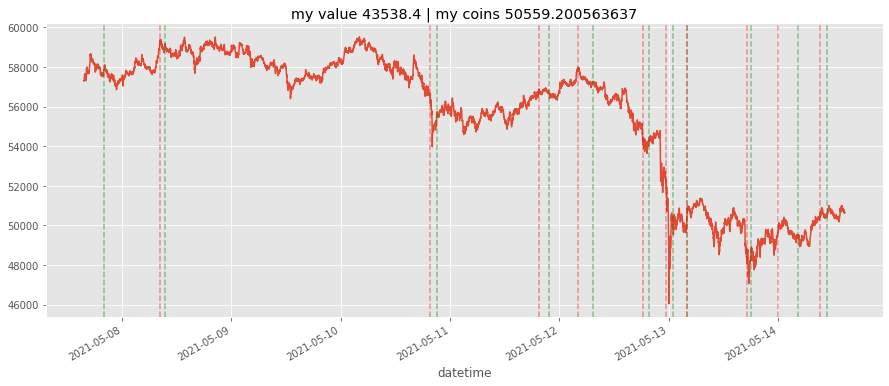

In [98]:
df['price'].loc['2021'].iloc[idxx:idxx+i].plot(title=f'my value {cross_bot.deposit:.1f} | my coins {np.sum(list(cross_bot.coin_pool.values()))}')
[plt.axvline(dt,linestyle='--',color='g',alpha=.4) for dt in cross_bot.deals_dict['buy']];
[plt.axvline(dt,linestyle='--',color='r',alpha=.4) for dt in cross_bot.deals_dict['sell']];


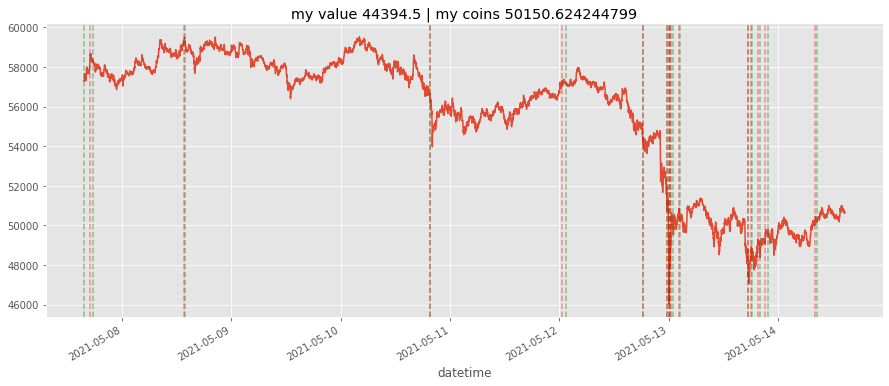

In [99]:
df['price'].loc['2021'].iloc[idxx:idxx+i].plot(title=f'my value {under_bot.deposit:.1f} | my coins {np.sum(list(under_bot.coin_pool.values()))}')
[plt.axvline(dt,linestyle='--',color='g',alpha=.4) for dt in under_bot.deals_dict['buy']];
[plt.axvline(dt,linestyle='--',color='r',alpha=.4) for dt in under_bot.deals_dict['sell']];


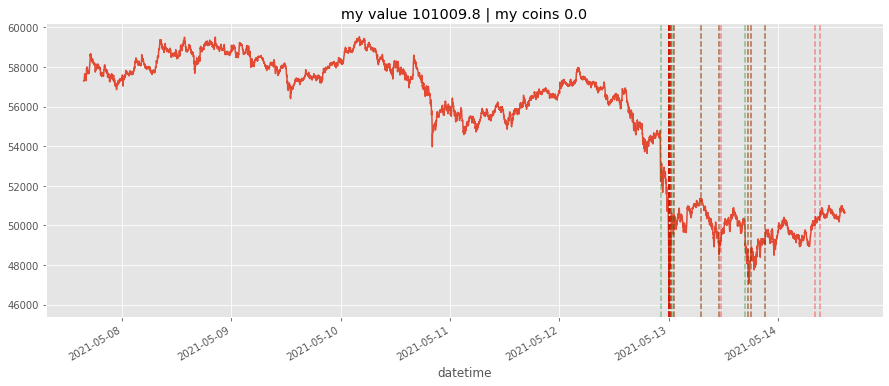

In [100]:
# Визуальный ряд с инфой где мы закупались и где продавали
df['price'].loc['2021'].iloc[idxx:idxx+i].plot(title=f'my value {mfi_bot.deposit:.1f} | my coins {np.sum(list(mfi_bot.coin_pool.values()))}')
[plt.axvline(dt,linestyle='--',color='g',alpha=.4) for dt in mfi_bot.deals_dict['buy']];
[plt.axvline(dt,linestyle='--',color='r',alpha=.4) for dt in mfi_bot.deals_dict['sell']];


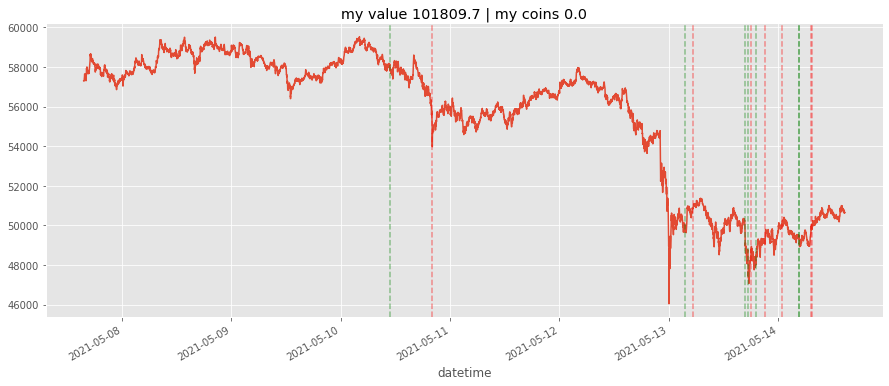

In [101]:
# Визуальный ряд с инфой где мы закупались и где продавали
df['price'].loc['2021'].iloc[idxx:idxx+i].plot(title=f'my value {div_bot.deposit:.1f} | my coins {np.sum(list(div_bot.coin_pool.values()))}')
[plt.axvline(dt,linestyle='--',color='g',alpha=.4) for dt in div_bot.deals_dict['buy']];
[plt.axvline(dt,linestyle='--',color='r',alpha=.4) for dt in div_bot.deals_dict['sell']];


In [46]:
df['h'] = (df.index + pd.Timedelta(8,unit='H')).hour

In [183]:
df['h7_rmean']=df['price'].pct_change().rolling(60*7).sum()

In [255]:
china_night_index = df.fillna(0).query('h7_rmean > .1 & h<7').index

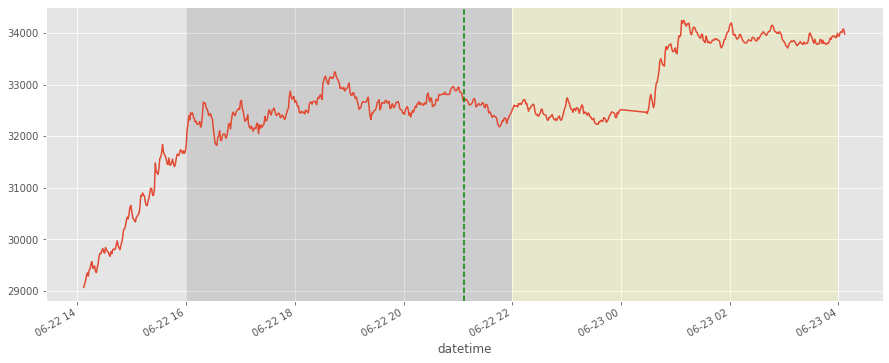

In [270]:
idx = np.random.choice(china_night_index)
hom_df = df.loc[idx-pd.Timedelta(7,unit='h'):idx+pd.Timedelta(7,unit='h')]
hom_df['price'].plot()
plt.axvline(idx,linestyle='--',color='green')
plt.axvspan(*hom_df.query('h<6').iloc[[0,-1]].index,color='black',alpha=.1)
plt.axvspan(*hom_df.query('h>=6 & h<12').iloc[[0,-1]].index,color='yellow',alpha=.1)

In [12]:
dd = df.loc['2021':]

<AxesSubplot:>

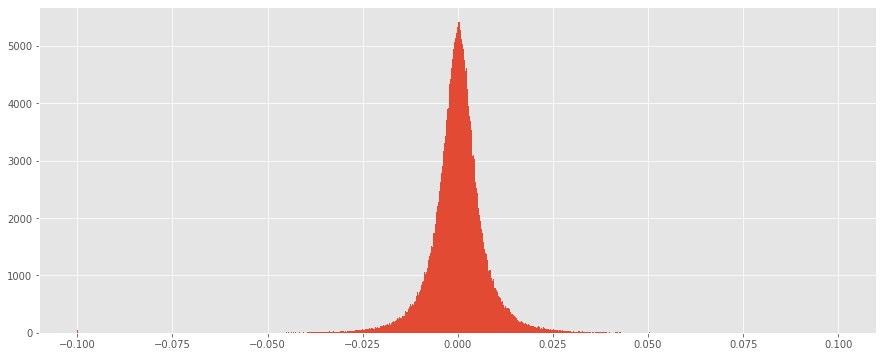

In [13]:
dd['price'].pct_change().rolling(30,1).sum().clip(-0.1,.1).hist(bins=1000)

In [185]:
target_index = dd['price'].pct_change().rolling(30,1).sum().where(lambda x: x>.005).dropna().index

In [186]:
dd['target'] = dd.index.isin(target_index).astype(int)
dd['target'] = dd['target'].shift(-30)


In [187]:
def get_features(df,price_col='price',vol_col='volume'):
    dd = df[[price_col,vol_col]].copy()
    for i in range(5,120,30):
        dd[f'price_r{i}_mean'] = dd[price_col].rolling(i,1).mean()
        dd[f'price_r{i}_std'] = dd[price_col].rolling(i,1).mean()
        dd[f'price_r{i}_diff'] = dd[price_col].rolling(i,1).max() - dd[price_col].rolling(i,1).min()

        dd[f'volume_r{i}_mean'] = dd[vol_col].rolling(i,1).mean()
        dd[f'volume_r{i}_sum'] = dd[vol_col].rolling(i,1).sum()
        dd[f'volume_r{i}_std'] = dd[vol_col].rolling(i,1).mean()
        dd[f'volume_r{i}_diff'] = dd[vol_col].rolling(i,1).max() - dd[vol_col].rolling(i,1).min()
    return dd.dropna()

In [188]:
data = get_features(dd)
target = dd['target']

In [189]:
rdd = data.join(target).query('target!=True').sample(20000).append(data.join(target).query('target==True')).sort_index().dropna()

In [190]:
from sklearn import *

In [191]:
x,xv,y,yv = model_selection.train_test_split(rdd.drop('target',axis=1),rdd['target'], test_size=.7,shuffle=False)

In [192]:
lr = linear_model.LogisticRegression(max_iter=1000,C=.1,class_weight=y.value_counts(normalize=True).to_dict())
pipe = pipeline.make_pipeline(preprocessing.StandardScaler(),linear_model.LogisticRegression(max_iter=1000,C=1,class_weight=y.value_counts(normalize=True).to_dict()))

In [193]:
model_selection.cross_validate(estimator=lr,X=x,y=y,cv=model_selection.StratifiedKFold(n_splits=5),scoring=['f1','precision','recall',])

{'fit_time': array([0.64963484, 0.44205737, 0.25362635, 0.14225817, 0.09419227]),
 'score_time': array([0.00809622, 0.01088285, 0.0075016 , 0.00693321, 0.0082438 ]),
 'test_f1': array([0.89037596, 0.89037596, 0.89051095, 0.8904843 , 0.8904843 ]),
 'test_precision': array([0.80241228, 0.80241228, 0.80263158, 0.80258829, 0.80258829]),
 'test_recall': array([1., 1., 1., 1., 1.])}

In [194]:
model_selection.cross_validate(estimator=pipe,X=x,y=y,cv=model_selection.StratifiedKFold(n_splits=5),scoring=['f1','precision','recall',])

{'fit_time': array([0.40272617, 0.11503196, 0.09122777, 0.12306666, 0.12671208]),
 'score_time': array([0.00761104, 0.00839949, 0.00743413, 0.00753474, 0.00763559]),
 'test_f1': array([0.89037596, 0.89037596, 0.89051095, 0.8904843 , 0.8904843 ]),
 'test_precision': array([0.80241228, 0.80241228, 0.80263158, 0.80258829, 0.80258829]),
 'test_recall': array([1., 1., 1., 1., 1.])}

In [195]:
lr.fit(x,y)
pipe.fit(x,y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=1,
                                    class_weight={0.0: 0.19747346258443724,
                                                  1.0: 0.8025265374155628},
                                    max_iter=1000))])

In [196]:
pd.crosstab(lr.predict_proba(xv)[:,1] > .99,yv)

target,0.0,1.0
row_0,,
False,15364,36517
True,133,1183


In [197]:
pd.crosstab(pipe.predict_proba(xv)[:,1] > .99,yv)

target,0.0,1.0
row_0,,
False,15465,37340
True,32,360


In [224]:
dft = df.loc['2021']

In [225]:
dft ['result'] = pipe.predict_proba(get_features(dft))[:,1]>.99
dft ['result_2'] = lr.predict_proba(get_features(dft))[:,1]>.99

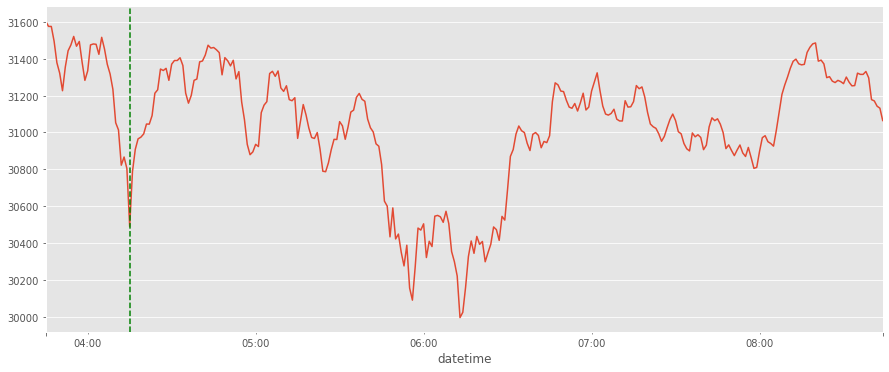

In [243]:
idx = np.random.randint(dft.shape[0]-300)
dft['price'].iloc[idx:idx+300].plot()
[plt.axvline(i,color='g',linestyle='--') for i in dft.iloc[idx:idx+300]['result'].where(lambda x: x==True).dropna().index];
[plt.axvline(i,color='b',linestyle='--') for i in dft.iloc[idx:idx+300]['result_2'].where(lambda x: x==True).dropna().index];